# *Stimulation file for pClamp - brain slices protocol* 

### *Poisson-like stimulations for 5 construct project*

*This script will generate an atf stimulus file for pClamp. In the current stimulation file, we are generating poisson-like stimulations in different frequencies (5,10,20,40,80) plus another atf file containing camera triggering for python-micromanager synchronization*

*We will stimulate the cells in a Poisson-like process, meaning that in every time interval we know what is the most probale number of events (stimulation) to occur, but we cannot say anything about the exact timing of those events. the file will constain 6 sweeps of ~12 seconds in total*   
*The general idea behind this stimulation-file is to stimulate the cells in a more natural way.*

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [163]:
ATF_HEADER="""
ATF	1.0
8	2
"AcquisitionMode=Episodic Stimulation"
"Comment="
"YTop=50"
"YBottom=-50"
"SyncTimeUnits=20"
"SweepStartTimesMS=0.000"
"SignalsExported=IN 0,Trigger"
"Signals="	"IN 0"  "Trigger"    
"Time (s)"	"Trace #1"  "Trace #2"  "Trace #3  "Trace #4"  "Trace #5"   "Trace #6"
""".strip()

def create_atf(data, filename, rate=20000):
    out=ATF_HEADER
    for i,row in data.iterrows():
        time_stamp,sweep1,sweep2,sweep3,sweep4,sweep5,sweep6 = row
        out+="\n%.05f\t%.05f\t%.05f\t%.05f\t%.05f\t%.05f\t%.05f"%(time_stamp,sweep1,sweep2,sweep3,sweep4,sweep5,sweep6)
    with open(filename,'w') as f:
        f.write(out)
        print("wrote",filename)
    return


### *generating the stimulation file*

*We can sample from uniform distrinution of our interval options (between the different HZ of stimulations 5,10,20,40,80). The intervals are: 
195ms,95ms,45ms,20ms,7.5ms between every stimulation*


In [164]:
# defining variables:

sample_rate      = 20000
start_end_silent = np.ones(2*sample_rate)*5 ##  just a short segment of nothing to add in the begining of the file.

# Let's take the interval options and convert it to samples.
interval_sample_5_hz  = np.ones(int(np.round(sample_rate/(1000/195))))*5
interval_sample_10_hz = np.ones(int(np.round(sample_rate/(1000/95))))*5
interval_sample_20_hz = np.ones(int(np.round(sample_rate/(1000/45))))*5
interval_sample_40_hz = np.ones(int(np.round(sample_rate/(1000/20))))*5
interval_sample_80_hz = np.ones(int(np.round(sample_rate/(1000/7.5))))*5

stimulus_samples_num = np.zeros(int(np.round(sample_rate/(1000/5))))


### *Building the Poisson-like stimulation*

In [165]:
sweep_seq = [start_end_silent]
stimulus_counter = 0
amount_of_stimulations = 100
while stimulus_counter<amount_of_stimulations:
    interval = np.random.randint(1,6)
    match interval:
        case 1:
            sweep_seq.append(interval_sample_5_hz)
        case 2:
            sweep_seq.append(interval_sample_10_hz)
        case 3:
            sweep_seq.append(interval_sample_20_hz)
        case 4:
            sweep_seq.append(interval_sample_40_hz)
        case 5:
            sweep_seq.append(interval_sample_80_hz)
    sweep_seq.append(stimulus_samples_num)
    stimulus_counter+=1
sweep_seq.append(start_end_silent)
sweep_seq = np.concatenate(sweep_seq) 


*This is how the stimulations look like*

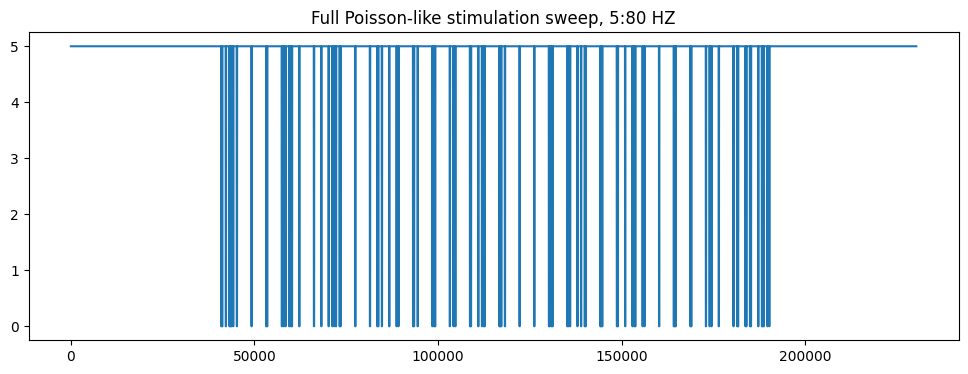

In [172]:
plt.figure(figsize=[12,4])
plt.plot(sweep_seq)
plt.title("Full Poisson-like stimulation sweep, 5:80 HZ")
plt.show()

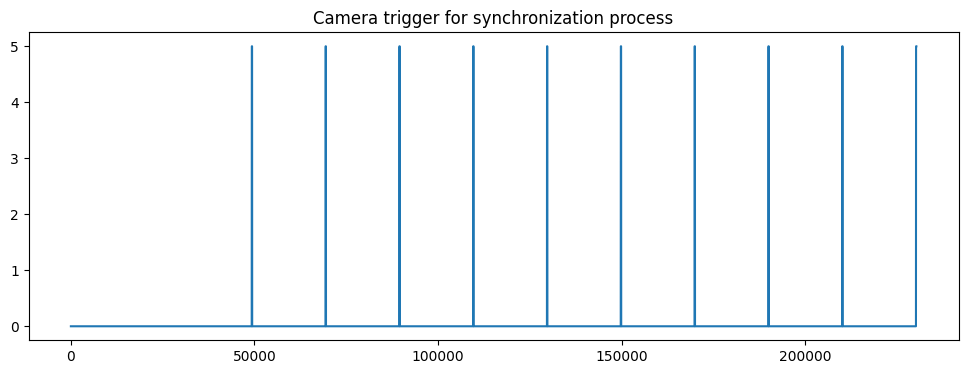

In [171]:
cam_trig_seq = []
empty_sec = np.zeros(sample_rate)
cam_trig  = np.ones(int((sample_rate*5)/1000))*5
for trig in range(10):
    cam_trig_seq.append(empty_sec)
    cam_trig_seq.append(cam_trig)
cam_trig_concat = np.concatenate(cam_trig_seq)

diff_len = len(sweep_seq)-len(cam_trig_concat)
cam_trig_seq = [np.zeros(diff_len),cam_trig_concat]
cam_trig_final =   np.concatenate(cam_trig_seq)

plt.figure(figsize=[12,4])
plt.plot(cam_trig_final)
plt.title("Camera trigger for synchronization process")
plt.show()

### *Writing the Data table for the ATF file generator*

In [167]:
sweep_length = len(sweep_seq)/sample_rate
data = pd.DataFrame(columns=['Time','Sweep1','Trigger_cam1','Sweep2','Trigger_cam2','Sweep3','Trigger_cam3','Sweep4','Trigger_cam4','Sweep5','Trigger_cam5','Sweep6','Trigger_cam6'])
for col in data.columns[1::2]:
    data[col] = sweep_seq
for col in data.columns[2::2]:
    data[col] = cam_trig_final
time_stamps    = np.arange(0,sweep_length,1/sample_rate)
data['Time'] = time_stamps
data_light_trig = data.iloc[:,1::2]
data_light_trig = pd.concat([data['Time'],data_light_trig],axis = 1)
data_cam_trig = data.iloc[:,2::2]
data_cam_trig = pd.concat([data['Time'],data_cam_trig],axis = 1)
data.head()

,Time,Sweep1,Trigger_cam1,Sweep2,Trigger_cam2,Sweep3,Trigger_cam3,Sweep4,Trigger_cam4,Sweep5,Trigger_cam5,Sweep6,Trigger_cam6
0,0.00000,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0
1,0.00005,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0
2,0.00010,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0
3,0.00015,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0
4,0.00020,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0


In [168]:
create_atf(data_light_trig,"light_trigger_poisson.atf")
create_atf(data_cam_trig,"cam_trigger_poisson.atf")

wrote light_trigger_poisson.atf
wrote cam_trigger_poisson.atf


*Done!* 
*We have generated an atf file, we can now upload it to pClamp*. 